# HRP Asset Allocation

This notebook is to look at HRP implementation.

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.linalg import block_diag

import seaborn as sns

### Retrive Data

In [94]:
from ipynb.fs.full.get_data import Data
# Not in notebook, but I created a class to help me retrieve and format data from quandl
start_date = '2016-01-01'
end_date = '2018-01-01'
symbols = ['AMZN', 'AAPL', 'GOOG', 'FB','JPM','GS']

df = pd.DataFrame()
df_list = []
for symbol in symbols:
    quandl= Data('', start_date, end_date).get_data(symbol)
    quandl['Returns'] = quandl['Close'].pct_change()
    df = quandl[['Symbol','Date','Close','Returns']]
    df_list.append(df)
df = pd.concat(df_list)
df.dropna(inplace=True)

In [95]:
def plot_matrix(element,labels=None):
    ax = sns.heatmap(element, cmap="YlGnBu")
    plt.show()


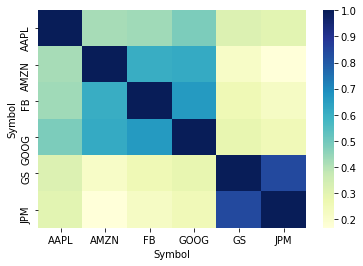

In [96]:
df_group = df.pivot('Date','Symbol')['Returns']
corr, cov = df_group.corr(), df_group.cov()
plot_matrix(corr, labels=df[['Symbol']])

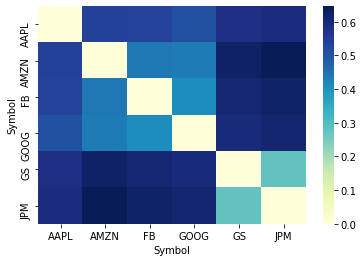

In [97]:
# EDA on distance
dist = correlation_distance(corr)
plot_matrix(dist)

### Updating the cluster
Updates the cluster by adding new unclustered item.
Would find the `min[di,j]`

The matrix is updated by adding the min and removing the cluster columns and rows.
It'll stop when all the cluster is found

In [98]:
def inverse_var_weights(cov):
    '''
    calc the inverse variance to min var of the weighted avg.
    '''
    inverse_var = 1./np.diag(cov)
    return inverse_var /inverse_var.sum()

In [84]:
def cluster_var_port(cov, items):
    """
    select the cov pairs and get their inverse var weight, then cluster
    """
    cov_sel = cov.loc[items, items]
    w = inverse_var_weights(cov_sel).reshape(-1,1)
    cluster_var = np.dot((w.T@cov_sel), w)[0,0]
    return cluster_var

### Quasi Diagonal
Quasi diagonal will end up with the largest value along the diagonal.
* Each row of linkage merges two branches into one
We replace clusters recursively until no clusters remain

In [85]:
def quasi_diagonal(link):
    '''
    sort cluster by distance. This allow similar investments to be placed together.
    Distributing weights optimally by using inverse-variance allocation.
    '''
    link = link.astype(int)
    sort_idx = pd.Series([link[-1,0], link[-1,1]])
    num_items = link[-1,3]
    while sort_idx.max() >= num_items:
        sort_idx.index = range(0, sort_idx.shape[0]*2,2)
        df = sort_idx[sort_idx >= num_items]
        i = df.index
        j = df.values - num_items
        sort_idx[i] = link[j,0]
        df = pd.Series(link[j,1], index=i+1)
        sort_idx = sort_idx.append(df)
        sort_idx.index = range(sort_idx.sort_index().shape[0])
    return sort_idx.tolist()

### Recursive bisect
* get a list of cluster items
* assign weight to all items at w(n) =1
* if len L is 1, then it stops
* If not, then it bisects two groups, where one is preserved and the other is 1/2|L|
* alpha is the split factor for the pairs weight

In [100]:
def recursive_bisec(cov, sort_idx):
    """
    allocation is based on cluster covriance. Obtains the cluster using bisectional method.
    Each bisection is weighted by inverse variance
    """
    w = pd.Series(1, index=sort_idx)
    cluster_items = [sort_idx]
    while len(cluster_items) > 0 :
        # bisection, one is preserved, the other half length
        cluster_items = [i[j:k] for i in cluster_items for j,k in ((0, len(i)//2), (len(i)//2, len(i))) if len(i)>1]
        
        #creates the pairs
        for i in range(0, len(cluster_items), 2):
            cluster_1, cluster_2 = cluster_items[i], cluster_items[i+1]
            cluster_var1, cluster_var2 = cluster_var_port(cov, cluster_1), cluster_var_port(cov, cluster_2)
            alpha = 1- cluster_var1/(cluster_var1+cluster_var2)
            w[cluster_1] *= alpha 
            w[cluster_2] *= 1-alpha
    return w

Calculate the distance of the correlation matrix D(i,j)

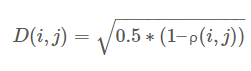

In [101]:
def correlation_distance(corr):
    return ((1-corr)*0.5)**0.5

### Run HRP

In [102]:
# scipy linkage defaults to euclidean distance, method of single
# where single-linkage cluster combines two clusters that contain the closest pair
group = linkage(dist)
sort_index = quasi_diagonal(group)
sort_index = corr.index[sort_index].tolist()
df = corr.loc[sort_index, sort_index]

#allocation
x = recursive_bisec(cov, sort_index)
x.sort_index()

c:\users\lynnj\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


AAPL    0.173706
AMZN    0.162861
FB      0.119123
GOOG    0.193439
GS      0.175023
JPM     0.175849
dtype: float64